In [136]:
#!pip install yfinance
#!pip install pandas-ta

In [137]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [138]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [139]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="1000d", interval="1d")
df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(1000, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000
1,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000
2,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000
3,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000
4,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000
...,...,...,...,...,...,...,...
995,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000
996,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000
997,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000
998,2022-03-03,4401.310059,4416.779785,4345.560059,4363.490234,4363.490234,4062080000


In [140]:
df_analisys.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [141]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_daily_raw' + '.pkl')
print(df_analisys.shape)

(1000, 7)


# Candles computations

In [142]:
#Fixes the trading date
df_analisys['Date'] = df_analisys['Date'].dt.tz_localize(None)
df_analisys['Date']

0     2018-03-16
1     2018-03-19
2     2018-03-20
3     2018-03-21
4     2018-03-22
         ...    
995   2022-02-28
996   2022-03-01
997   2022-03-02
998   2022-03-03
999   2022-03-04
Name: Date, Length: 1000, dtype: datetime64[ns]

In [143]:
df_analisys['date'] = df_analisys['Date']
df_analisys['date']

0     2018-03-16
1     2018-03-19
2     2018-03-20
3     2018-03-21
4     2018-03-22
         ...    
995   2022-02-28
996   2022-03-01
997   2022-03-02
998   2022-03-03
999   2022-03-04
Name: date, Length: 1000, dtype: datetime64[ns]

In [144]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098
1,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834
2,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000
3,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893
4,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000,2018-03-22,-47.670166,47.670166,4.319824,2.099854
5,2018-03-23,2646.709961,2657.669922,2585.889893,2588.260010,2588.260010,3815080000,2018-03-23,-58.449951,58.449951,10.959961,2.370117
6,2018-03-26,2619.350098,2661.360107,2601.810059,2658.550049,2658.550049,3511100000,2018-03-26,39.199951,39.199951,2.810059,17.540039
7,2018-03-27,2667.570068,2674.780029,2596.120117,2612.620117,2612.620117,3706350000,2018-03-27,-54.949951,54.949951,7.209961,16.500000
8,2018-03-28,2611.300049,2632.649902,2593.060059,2605.000000,2605.000000,3864500000,2018-03-28,-6.300049,6.300049,21.349854,11.939941
9,2018-03-29,2614.409912,2659.070068,2609.719971,2640.870117,2640.870117,3565990000,2018-03-29,26.460205,26.460205,18.199951,4.689941


In [145]:
#Computes candles color
df_analisys['body_disposal']=None
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1      0            454
0      1            546


# Target signal

In [208]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    profit_threshold = 60
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        s_threshold = ((df_analisys['Close'][i] - df_analisys['Close'].iloc[i+1:]).abs() > profit_threshold)
        idxs = s_threshold[s_threshold].index
        
        try:
            target_idx = [min(idxs)]
        except:
            target_idx = []
        
        df_data = df_analisys.iloc[target_idx]

        Datetime = df_analisys['date'][i]

        keepcols = ['date','Close']
        df_data = df_data[keepcols]

        dic_rencols = {
            'date':'target_date',
            'Close': 'target_close',
        }

        df_data = df_data.rename(columns=dic_rencols)
        df_data['date'] = Datetime

        if i == 0:
            df_target =df_data.copy()
        else:
            df_target =df_target.append(df_data).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,target_date,target_close,date
0,2018-03-22,2643.689941,2018-03-16
1,2018-03-22,2643.689941,2018-03-19
2,2018-03-22,2643.689941,2018-03-20
3,2018-03-22,2643.689941,2018-03-21
4,2018-04-02,2581.879883,2018-03-22
...,...,...,...
992,2022-02-24,4288.700195,2022-02-23
993,2022-02-25,4384.649902,2022-02-24
994,2022-03-01,4306.259766,2022-02-25
995,2022-03-01,4306.259766,2022-02-28


In [209]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['date'],
                         how = 'left').copy()

#Computes the target difference in closure prices
df_analisys_01['target_difference'] =  round( df_analisys_01['target_close'] - df_analisys_01['Close'] )

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_difference'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(1000, 13)
(1000, 16)
     index  target_difference
153 -325.0                  1
148 -277.0                  1
150 -261.0                  1
127 -230.0                  1
149 -226.0                  1
..     ...                ...
156  183.0                  1
137  193.0                  1
155  210.0                  1
152  230.0                  1
89     NaN                  3

[163 rows x 2 columns]


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference
0,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098,1,2018-03-22,2643.689941,-108.0
1,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834,0,2018-03-22,2643.689941,-69.0
2,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000,1,2018-03-22,2643.689941,-73.0
3,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893,0,2018-03-22,2643.689941,-68.0
4,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000,2018-03-22,-47.670166,47.670166,4.319824,2.099854,0,2018-04-02,2581.879883,-62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,14.899902,39.049805,1,2022-03-01,4306.259766,-68.0
996,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,15.310059,26.719727,0,2022-03-02,4386.540039,80.0
997,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,14.939941,0.000000,1,NaT,NaN,NaN
998,2022-03-03,4401.310059,4416.779785,4345.560059,4363.490234,4363.490234,4062080000,2022-03-03,-37.819824,37.819824,15.469727,17.930176,0,NaT,NaN,NaN


In [210]:
df_varbins = df_analisys_01[['target_difference']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_difference'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_bins
20                 00-nan            3
9   01-(-325.001, -126.4]           50
4     02-(-126.4, -109.0]           52
11     03-(-109.0, -96.0]           49
10      04-(-96.0, -87.8]           49
2       05-(-87.8, -79.0]           56
16      06-(-79.0, -72.0]           44
12      07-(-72.0, -64.4]           49
0        08-(-64.4, 60.0]           74
17        09-(60.0, 61.0]           40
1         10-(61.0, 63.0]           61
18        11-(63.0, 64.0]           40
3         12-(64.0, 66.0]           52
6         13-(66.0, 68.0]           51
15        14-(68.0, 70.0]           46
19        15-(70.0, 72.0]           36
13        16-(72.0, 75.0]           49
7         17-(75.0, 79.0]           50
5         18-(79.0, 84.0]           51
8         19-(84.0, 96.0]           50
14       20-(96.0, 230.0]           48


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [211]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['date']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference,target_date_diff
0,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,9.840088,0.600098,1,2018-03-22,2643.689941,-108.0,8640.0
1,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,0.000000,18.329834,0,2018-03-22,2643.689941,-69.0,4320.0
2,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,7.280029,5.000000,1,2018-03-22,2643.689941,-73.0,2880.0
3,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,24.149902,2.139893,0,2018-03-22,2643.689941,-68.0,1440.0
4,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000,2018-03-22,-47.670166,47.670166,4.319824,2.099854,0,2018-04-02,2581.879883,-62.0,15840.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,14.899902,39.049805,1,2022-03-01,4306.259766,-68.0,1440.0
996,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,15.310059,26.719727,0,2022-03-02,4386.540039,80.0,1440.0
997,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,14.939941,0.000000,1,NaT,NaN,NaN,NaN
998,2022-03-03,4401.310059,4416.779785,4345.560059,4363.490234,4363.490234,4062080000,2022-03-03,-37.819824,37.819824,15.469727,17.930176,0,NaT,NaN,NaN,NaN


In [212]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

df_obs = df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index'])

df_obs['pp_cases'] = df_obs['target_date_bins'] / sum(df_obs['target_date_bins'])

df_obs['app_cases'] = df_obs['pp_cases'].cumsum()

df_obs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,target_date_bins,pp_cases,app_cases
17,00-nan,3,0.003,0.003
0,"01-(1439.999, 2880.0]",145,0.145,0.148
8,"02-(2880.0, 4320.0]",55,0.055,0.203
6,"04-(4608.0, 5760.0]",58,0.058,0.261
3,"05-(5760.0, 7200.0]",63,0.063,0.324
2,"06-(7200.0, 8640.0]",66,0.066,0.390
1,"07-(8640.0, 10080.0]",75,0.075,0.465
7,"08-(10080.0, 11520.0]",57,0.057,0.522
15,"09-(11520.0, 12960.0]",40,0.040,0.562
4,"10-(12960.0, 15840.0]",61,0.061,0.623


In [213]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

11520.0

In [214]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0     1440.0
1    10080.0
dtype: float64


In [215]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_difference'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_difference'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_difference'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_difference'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'


df_analisys_01.loc[abs(df_analisys_01['target_difference']) < profit_threshold, 'target_order'] = 'NULL'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'] == 'BUY', 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
1    BUY           293
0   BUY2           310
4   NULL             3
2   SELL           226
3  SELL2           168
   index  target_order_bin
0      0               707
1      1               293


# MACD and EMA indicators

In [216]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys_01.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
995,-59.780003,-4.175605,-55.604399
996,-61.112304,-4.406324,-56.705980
997,-55.055569,1.320329,-56.375897
998,-51.521580,3.883454,-55.405034


In [217]:
ewm50 = df_analisys_01['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys_01['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys_01['diff_ewm50'] = df_analisys_01['Close'] - ewm50
df_analisys_01['diff_ewm200'] = df_analisys_01['Close'] - ewm200

df_analisys_01

,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5372340000,2018-03-16,1.439941,1.439941,...,2643.689941,-108.0,8640.0,SELL,0,NaN,NaN,NaN,NaN,NaN
1,2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3302130000,2018-03-19,-28.459961,28.459961,...,2643.689941,-69.0,4320.0,SELL,0,NaN,NaN,NaN,NaN,NaN
2,2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3261030000,2018-03-20,1.889893,1.889893,...,2643.689941,-73.0,2880.0,SELL,0,NaN,NaN,NaN,NaN,NaN
3,2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3415510000,2018-03-21,-3.060059,3.060059,...,2643.689941,-68.0,1440.0,SELL,0,NaN,NaN,NaN,NaN,NaN
4,2018-03-22,2691.360107,2695.679932,2641.590088,2643.689941,2643.689941,3739800000,2018-03-22,-47.670166,47.670166,...,2581.879883,-62.0,15840.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,...,4306.259766,-68.0,1440.0,SELL,0,-59.780003,-4.175605,-55.604399,-123.620648,-31.540902
996,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,...,4386.540039,80.0,1440.0,BUY,1,-61.112304,-4.406324,-56.705980,-183.798830,-98.233803
997,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,...,NaN,NaN,NaN,NULL,0,-55.055569,1.320329,-56.375897,-99.459006,-17.774888
998,2022-03-03,4401.310059,4416.779785,4345.560059,4363.490234,4363.490234,4062080000,2022-03-03,-37.819824,37.819824,...,NaN,NaN,NaN,NULL,0,-51.521580,3.883454,-55.405034,-117.704543,-40.418477


In [218]:
#Keeps only the data where MACD is available

df_analisys_02 = df_analisys_01[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys_01.shape)
print(df_analisys_02.shape)

df_analisys_02

(1000, 24)
(801, 24)


,Date,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
199,2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000,2018-12-31,7.910156,7.910156,...,2574.409912,68.0,11520.0,BUY,1,-65.634808,-3.715851,-61.918956,-138.042109,-231.058694
200,2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000,2019-01-02,33.070068,33.070068,...,2447.889893,-62.0,1440.0,SELL,0,-60.803967,0.891991,-61.695959,-129.573464,-225.611312
201,2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000,2019-01-03,-44.030029,44.030029,...,2531.939941,84.0,1440.0,BUY,1,-61.283246,0.330170,-61.613416,-184.195420,-284.888251
202,2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000,2019-01-04,57.609863,57.609863,...,2596.639893,65.0,8640.0,BUY,1,-54.255518,5.886319,-60.141836,-96.218102,-198.839812
203,2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4104710000,2019-01-07,14.079834,14.079834,...,2610.300049,61.0,11520.0,BUY,1,-46.715212,10.741300,-57.456512,-75.390922,-179.287923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-28,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,4594010000,2022-02-28,19.770020,19.770020,...,4306.259766,-68.0,1440.0,SELL,0,-59.780003,-4.175605,-55.604399,-123.620648,-31.540902
996,2022-03-01,4363.140137,4378.450195,4279.540039,4306.259766,4306.259766,4679400000,2022-03-01,-56.880371,56.880371,...,4386.540039,80.0,1440.0,BUY,1,-61.112304,-4.406324,-56.705980,-183.798830,-98.233803
997,2022-03-02,4322.560059,4401.479980,4322.560059,4386.540039,4386.540039,4409090000,2022-03-02,63.979980,63.979980,...,NaN,NaN,NaN,NULL,0,-55.055569,1.320329,-56.375897,-99.459006,-17.774888
998,2022-03-03,4401.310059,4416.779785,4345.560059,4363.490234,4363.490234,4062080000,2022-03-03,-37.819824,37.819824,...,NaN,NaN,NaN,NULL,0,-51.521580,3.883454,-55.405034,-117.704543,-40.418477


In [219]:
df_varbins = df_analisys_02[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys_02[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys_02[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                      index  diff_bins
0   01-(-717.177, -156.642]         41
1    02-(-156.642, -67.432]         40
18    03-(-67.432, -26.291]         40
17      04-(-26.291, 2.639]         40
16       05-(2.639, 19.025]         40
14      06-(19.025, 38.663]         40
15      07-(38.663, 52.387]         40
13      08-(52.387, 65.015]         40
12      09-(65.015, 75.225]         40
9        10-(75.225, 85.93]         40
11       11-(85.93, 93.494]         40
10      12-(93.494, 99.785]         40
7       13-(99.785, 108.15]         40
8      14-(108.15, 114.846]         40
6     15-(114.846, 124.251]         40
5      16-(124.251, 132.82]         40
4      17-(132.82, 147.322]         40
2     18-(147.322, 161.233]         40
3     19-(161.233, 180.412]         40
19    20-(180.412, 294.653]         40
Absolute mean difference with:  diff_ewm50    105.900919
dtype: float64
Absolute mean difference with:  diff_ewm200    250.734794
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data preparation

In [220]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [221]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_close_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 130

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Close']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Close']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_close_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_close_' + str(x) for x in range(30,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_close_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_close_info['date'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss80_close_80,ss80_close_79,ss80_close_78,ss80_close_77,ss80_close_76,ss80_close_75,ss80_close_74,ss80_close_73,ss80_close_72,ss80_close_71,...,ss160_close_5,ss160_close_4,ss160_close_3,ss160_close_2,ss160_close_1,slope_close_0,slope_close_1,slope_close_2,slope_close_3,date
0,0.746324,0.484808,0.502180,0.730039,0.729698,0.852517,0.769530,0.877218,0.832568,0.730649,...,-1.181020,-1.664874,-1.090941,-1.255726,-1.503230,-0.195662,-0.022331,0.083651,-0.045336,2022-03-04
1,0.837599,0.724452,0.459368,0.476977,0.707946,0.707600,0.832095,0.747975,0.857132,0.811873,...,-1.124050,-1.201281,-1.689334,-1.110420,-1.276636,0.196820,-0.020441,0.103032,-0.048759,2022-03-03
2,0.788255,0.817237,0.702921,0.435098,0.452888,0.686243,0.685894,0.811675,0.726686,0.836971,...,-1.831583,-1.135985,-1.213628,-1.704283,-1.122282,0.043780,0.081507,0.067214,-0.062457,2022-03-02
3,0.647424,0.769973,0.799228,0.683831,0.413475,0.431434,0.666996,0.666643,0.793614,0.707822,...,-2.306162,-1.845932,-1.147217,-1.225208,-1.718062,-0.274951,0.173100,-0.007498,-0.100218,2022-03-01
4,0.491176,0.631190,0.756688,0.786648,0.668473,0.391610,0.410001,0.651233,0.650872,0.780898,...,-1.758095,-2.341588,-1.876322,-1.169962,-1.248806,0.306171,0.213725,-0.080844,-0.133556,2022-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.070607,0.021795,-1.783865,0.658450,1.174227,1.479046,0.312632,NaN,NaN,2019-01-07
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.246339,0.348434,-1.646652,1.051879,0.351722,NaN,NaN,NaN,2019-01-04
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.650731,0.762022,-1.412753,-1.031742,NaN,NaN,NaN,2019-01-03
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2019-01-02


In [222]:
df_close_info_01[[
    'ss80_close_1',
    'ss80_close_2',
    'ss80_close_3',
    'ss80_close_4',
    
    'ss160_close_1',
    'ss160_close_2',
    'ss160_close_3',
    'ss160_close_4',
]]


,ss80_close_1,ss80_close_2,ss80_close_3,ss80_close_4,ss160_close_1,ss160_close_2,ss160_close_3,ss160_close_4
0,-1.671915,-1.436998,-1.280592,-1.825339,-1.503230,-1.255726,-1.090941,-1.664874
1,-1.488660,-1.330120,-1.882300,-1.416785,-1.276636,-1.110420,-1.689334,-1.201281
2,-1.372878,-1.930763,-1.460439,-1.386013,-1.122282,-1.704283,-1.213628,-1.135985
3,-1.974762,-1.499990,-1.424860,-2.097941,-1.718062,-1.225208,-1.147217,-1.845932
4,-1.567906,-1.490969,-2.180249,-2.634265,-1.248806,-1.169962,-1.876322,-2.341588
...,...,...,...,...,...,...,...,...
796,1.174227,0.658450,-1.783865,0.021795,1.174227,0.658450,-1.783865,0.021795
797,1.051879,-1.646652,0.348434,0.246339,1.051879,-1.646652,0.348434,0.246339
798,-1.412753,0.762022,0.650731,NaN,-1.412753,0.762022,0.650731,NaN
799,1.000000,-1.000000,NaN,NaN,1.000000,-1.000000,NaN,NaN


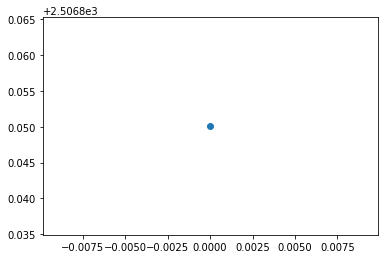

In [223]:
data = X
plt.scatter(range(0,len(data)), data)
plt.show()

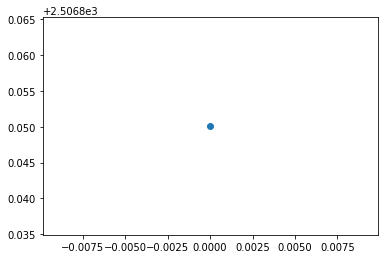

In [224]:
data = X2
plt.scatter(range(0,len(data)), data)
plt.show()

In [225]:
ls_ss160vars = ['ss160_close_' + str(x) for x in range(30,0,-1)]
ls_ss160vars

['ss160_close_30',
 'ss160_close_29',
 'ss160_close_28',
 'ss160_close_27',
 'ss160_close_26',
 'ss160_close_25',
 'ss160_close_24',
 'ss160_close_23',
 'ss160_close_22',
 'ss160_close_21',
 'ss160_close_20',
 'ss160_close_19',
 'ss160_close_18',
 'ss160_close_17',
 'ss160_close_16',
 'ss160_close_15',
 'ss160_close_14',
 'ss160_close_13',
 'ss160_close_12',
 'ss160_close_11',
 'ss160_close_10',
 'ss160_close_9',
 'ss160_close_8',
 'ss160_close_7',
 'ss160_close_6',
 'ss160_close_5',
 'ss160_close_4',
 'ss160_close_3',
 'ss160_close_2',
 'ss160_close_1']

In [226]:
ls_ss80vars = ['ss80_close_' + str(x) for x in range(80,8,-1) ]
ls_ss80vars

['ss80_close_80',
 'ss80_close_79',
 'ss80_close_78',
 'ss80_close_77',
 'ss80_close_76',
 'ss80_close_75',
 'ss80_close_74',
 'ss80_close_73',
 'ss80_close_72',
 'ss80_close_71',
 'ss80_close_70',
 'ss80_close_69',
 'ss80_close_68',
 'ss80_close_67',
 'ss80_close_66',
 'ss80_close_65',
 'ss80_close_64',
 'ss80_close_63',
 'ss80_close_62',
 'ss80_close_61',
 'ss80_close_60',
 'ss80_close_59',
 'ss80_close_58',
 'ss80_close_57',
 'ss80_close_56',
 'ss80_close_55',
 'ss80_close_54',
 'ss80_close_53',
 'ss80_close_52',
 'ss80_close_51',
 'ss80_close_50',
 'ss80_close_49',
 'ss80_close_48',
 'ss80_close_47',
 'ss80_close_46',
 'ss80_close_45',
 'ss80_close_44',
 'ss80_close_43',
 'ss80_close_42',
 'ss80_close_41',
 'ss80_close_40',
 'ss80_close_39',
 'ss80_close_38',
 'ss80_close_37',
 'ss80_close_36',
 'ss80_close_35',
 'ss80_close_34',
 'ss80_close_33',
 'ss80_close_32',
 'ss80_close_31',
 'ss80_close_30',
 'ss80_close_29',
 'ss80_close_28',
 'ss80_close_27',
 'ss80_close_26',
 'ss80_clo

In [227]:
ls_ss80vars2 = ['ss80_close_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

['ss80_close_8',
 'ss80_close_7',
 'ss80_close_6',
 'ss80_close_5',
 'ss80_close_4',
 'ss80_close_3',
 'ss80_close_2',
 'ss80_close_1']

In [228]:
ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_close_0', 'slope_close_1', 'slope_close_2', 'slope_close_3']

In [229]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss80vars2] = df_close_info_01[ls_ss80vars2].astype(float)
df_close_info_01[ls_ss80vars] = df_close_info_01[ls_ss80vars].astype(float)
df_close_info_01[ls_ss160vars] = df_close_info_01[ls_ss160vars].astype(float)
df_close_info_01[ls_slopevars] = df_close_info_01[ls_slopevars].astype(float)

In [230]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Columns: 114 entries, slope_close_0 to ss160_close_1
dtypes: float64(114)
memory usage: 648.7 KB


In [231]:
#Defines X vector to all process

X = df_close_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(722, 114)


In [232]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [233]:
Xtr.shape

(722, 18)

In [234]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_close_c1','ss80_close_c2','ss80_close_c3']
ls_ss160pcavars = ['ss160_close_c1','ss160_close_c2','ss160_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(722, 18)


,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,-0.195662,-0.022331,0.083651,-0.045336,-2.373340,-1.944491,-1.293418,-1.366091,-1.825339,-1.280592,-1.436998,-1.671915,9.119725,-3.648056,-0.790167,9.579578,0.250855,2.161755
1,0.196820,-0.020441,0.103032,-0.048759,-1.892617,-2.437777,-2.003077,-1.343120,-1.416785,-1.882300,-1.330120,-1.488660,8.921993,-3.616262,-1.084138,9.469622,0.155303,2.346573
2,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,-1.460439,-1.930763,-1.372878,8.736154,-3.583610,-1.429877,9.340444,0.180193,2.424105
3,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,-1.424860,-1.499990,-1.974762,8.548311,-3.558666,-1.792790,9.210007,0.299829,2.387142
4,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,-2.180249,-1.490969,-1.567906,8.464812,-3.648058,-2.238802,8.936108,0.403311,1.941433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,-0.092560,0.001027,0.026505,0.032828,1.228061,1.474664,1.412990,1.402630,1.534132,1.564348,1.591205,1.379227,-2.864330,-0.719736,1.628949,-1.025869,-1.030374,0.325351
718,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,1.546879,1.576440,1.602716,-2.854194,-0.835772,1.609047,-0.992373,-1.088474,0.204553
719,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,1.419385,1.543053,1.571468,-2.817036,-1.013052,1.634556,-0.948209,-1.078269,0.126584
720,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,1.452844,1.443267,1.564834,-2.838353,-1.136406,1.585158,-0.900298,-1.071998,0.061237


In [235]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['date'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,date,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,2022-03-04,-0.195662,-0.022331,0.083651,-0.045336,-2.373340,-1.944491,-1.293418,-1.366091,-1.825339,-1.280592,-1.436998,-1.671915,9.119725,-3.648056,-0.790167,9.579578,0.250855,2.161755
1,2022-03-03,0.196820,-0.020441,0.103032,-0.048759,-1.892617,-2.437777,-2.003077,-1.343120,-1.416785,-1.882300,-1.330120,-1.488660,8.921993,-3.616262,-1.084138,9.469622,0.155303,2.346573
2,2022-03-02,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,-1.460439,-1.930763,-1.372878,8.736154,-3.583610,-1.429877,9.340444,0.180193,2.424105
3,2022-03-01,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,-1.424860,-1.499990,-1.974762,8.548311,-3.558666,-1.792790,9.210007,0.299829,2.387142
4,2022-02-28,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,-2.180249,-1.490969,-1.567906,8.464812,-3.648058,-2.238802,8.936108,0.403311,1.941433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-05-01,-0.092560,0.001027,0.026505,0.032828,1.228061,1.474664,1.412990,1.402630,1.534132,1.564348,1.591205,1.379227,-2.864330,-0.719736,1.628949,-1.025869,-1.030374,0.325351
718,2019-04-30,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,1.546879,1.576440,1.602716,-2.854194,-0.835772,1.609047,-0.992373,-1.088474,0.204553
719,2019-04-29,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,1.419385,1.543053,1.571468,-2.817036,-1.013052,1.634556,-0.948209,-1.078269,0.126584
720,2019-04-26,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,1.452844,1.443267,1.564834,-2.838353,-1.136406,1.585158,-0.900298,-1.071998,0.061237


## MACD info

### Histogram

In [236]:
for c in df_analisys_02.columns.tolist():
    print(c)

Date
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
target_date
target_close
target_difference
target_date_diff
target_order
target_order_bin
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [237]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macdh_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 130

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['MACDh_12_26_9']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['MACDh_12_26_9']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_macdh_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_macdh_' + str(x) for x in range(30,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macdh_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macdh_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_macdh_info['date'] = Datetime
    
    if i == 0:
        df_macdh_info_01 = df_macdh_info.copy()
    else:
        df_macdh_info_01 = df_macdh_info_01.append(df_macdh_info,sort=False).copy()
        
df_macdh_info_01 = df_macdh_info_01.reset_index(drop=True)
df_macdh_info_01

,ss80_macdh_80,ss80_macdh_79,ss80_macdh_78,ss80_macdh_77,ss80_macdh_76,ss80_macdh_75,ss80_macdh_74,ss80_macdh_73,ss80_macdh_72,ss80_macdh_71,...,ss160_macdh_5,ss160_macdh_4,ss160_macdh_3,ss160_macdh_2,ss160_macdh_1,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,date
0,1.223763,0.833432,0.539045,0.462833,0.372228,0.361033,0.260504,0.239036,0.165143,0.023887,...,-0.113014,-0.129474,0.279071,0.461927,0.440431,0.081659,0.171890,0.252749,0.016807,2022-03-04
1,1.409904,1.201807,0.815384,0.523945,0.448495,0.358797,0.347715,0.248192,0.226939,0.153786,...,-0.494798,-0.111894,-0.128361,0.280358,0.463292,0.296293,0.231207,0.211941,-0.019294,2022-03-03
2,1.453718,1.384515,1.178660,0.796401,0.508102,0.433465,0.344734,0.333771,0.235320,0.214296,...,-1.068430,-0.492871,-0.109691,-0.126170,0.282844,0.194319,0.303877,0.114374,-0.069371,2022-03-02
3,1.422198,1.424596,1.356194,1.152723,0.774890,0.489929,0.416157,0.328453,0.317617,0.220306,...,-1.129321,-1.068131,-0.492512,-0.109292,-0.125772,0.179428,0.290218,-0.006407,-0.126817,2022-03-01
4,1.371896,1.388288,1.390657,1.323075,1.122040,0.748731,0.467183,0.394293,0.307640,0.296933,...,-0.609166,-1.131097,-1.069906,-0.494274,-0.111045,0.463496,0.157879,-0.115719,-0.167847,2022-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.309665,-0.387295,-0.499757,0.612439,1.584279,1.042018,0.678762,NaN,NaN,2019-01-07
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.338835,0.012859,-0.151950,1.477926,0.732534,NaN,NaN,NaN,2019-01-04
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.405357,0.839535,0.565822,0.985589,NaN,NaN,NaN,2019-01-03
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2019-01-02


In [238]:
# Create variable names lists to naming columns

ls_ss160vars = ['ss160_macdh_' + str(x) for x in range(30,0,-1)]
ls_ss160vars

ls_ss80vars = ['ss80_macdh_' + str(x) for x in range(80,9,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macdh_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macdh_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macdh_0', 'slope_macdh_1', 'slope_macdh_2', 'slope_macdh_3']

In [239]:
#Assigns correct format to variable to apply transformations
df_macdh_info_01[ls_ss80vars2] = df_macdh_info_01[ls_ss80vars2].astype(float)
df_macdh_info_01[ls_ss80vars] = df_macdh_info_01[ls_ss80vars].astype(float)
df_macdh_info_01[ls_ss160vars] = df_macdh_info_01[ls_ss160vars].astype(float)
df_macdh_info_01[ls_slopevars] = df_macdh_info_01[ls_slopevars].astype(float)

In [240]:
df_macdh_info_01 = df_macdh_info_01[df_macdh_info_01.notna().all(axis=1)]

df_macdh_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Columns: 113 entries, slope_macdh_0 to ss160_macdh_1
dtypes: float64(113)
memory usage: 643.0 KB


In [241]:
#Defines X vector to all process

X = df_macdh_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(722, 113)


In [242]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [243]:
Xtr.shape

(722, 18)

In [244]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macdh_c1','ss80_macdh_c2','ss80_macdh_c3']
ls_ss160pcavars = ['ss160_macdh_c1','ss160_macdh_c2','ss160_macdh_c3']

df_macdh_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_macdh_info_tr_01.shape)
df_macdh_info_tr_01

(722, 18)


,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,0.081659,0.171890,0.252749,0.016807,-0.941447,-0.879592,-0.297717,0.089669,0.073010,0.486513,0.671588,0.649831,3.439488,-1.767748,1.568482,2.125183,-1.928952,3.732514
1,0.296293,0.231207,0.211941,-0.019294,-0.419415,-0.941725,-0.880489,-0.304439,0.079068,0.062575,0.471939,0.655161,3.371268,-0.953543,2.225127,2.652233,-1.825395,4.683332
2,0.194319,0.303877,0.114374,-0.069371,-0.061083,-0.425093,-0.941776,-0.881200,-0.311357,0.068018,0.051703,0.456656,3.186390,-0.097970,2.842148,3.111943,-1.594202,5.372527
3,0.179428,0.290218,-0.006407,-0.126817,0.263586,-0.072665,-0.432460,-0.943160,-0.883285,-0.320041,0.054942,0.038816,2.893611,0.766449,3.389721,3.519668,-1.208972,5.697767
4,0.463496,0.157879,-0.115719,-0.167847,0.598812,0.243550,-0.088675,-0.444162,-0.948746,-0.889589,-0.333089,0.037404,2.521932,1.571795,3.852828,3.894890,-0.656996,5.574217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,-0.111048,-0.029471,-0.002294,-0.018875,-0.657575,-0.515907,-0.515359,-0.560250,-0.511968,-0.493130,-0.496726,-0.715227,-4.015948,-2.311507,6.243624,0.312402,1.113816,2.363508
718,0.007644,0.010471,0.017947,-0.016036,-0.611734,-0.670794,-0.528689,-0.528140,-0.573169,-0.524739,-0.505843,-0.509450,-3.643076,-2.656835,6.425309,0.423089,1.228427,2.337698
719,0.033657,0.004909,0.010763,-0.022812,-0.530520,-0.611271,-0.670320,-0.528242,-0.527693,-0.572713,-0.524292,-0.505400,-3.152640,-3.027963,6.452909,0.492079,1.321505,2.324427
720,0.001701,0.024764,-0.008124,-0.031092,-0.401437,-0.531143,-0.611913,-0.670976,-0.528864,-0.528314,-0.573346,-0.524913,-2.612017,-3.352418,6.413765,0.583242,1.414995,2.300454


In [245]:
# Concat the Datetime to the transformed data

df_macdh_info_tr_01 = pd.concat([df_macdh_info_01['date'],df_macdh_info_tr_01],axis=1)
df_macdh_info_tr_01

,date,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,2022-03-04,0.081659,0.171890,0.252749,0.016807,-0.941447,-0.879592,-0.297717,0.089669,0.073010,0.486513,0.671588,0.649831,3.439488,-1.767748,1.568482,2.125183,-1.928952,3.732514
1,2022-03-03,0.296293,0.231207,0.211941,-0.019294,-0.419415,-0.941725,-0.880489,-0.304439,0.079068,0.062575,0.471939,0.655161,3.371268,-0.953543,2.225127,2.652233,-1.825395,4.683332
2,2022-03-02,0.194319,0.303877,0.114374,-0.069371,-0.061083,-0.425093,-0.941776,-0.881200,-0.311357,0.068018,0.051703,0.456656,3.186390,-0.097970,2.842148,3.111943,-1.594202,5.372527
3,2022-03-01,0.179428,0.290218,-0.006407,-0.126817,0.263586,-0.072665,-0.432460,-0.943160,-0.883285,-0.320041,0.054942,0.038816,2.893611,0.766449,3.389721,3.519668,-1.208972,5.697767
4,2022-02-28,0.463496,0.157879,-0.115719,-0.167847,0.598812,0.243550,-0.088675,-0.444162,-0.948746,-0.889589,-0.333089,0.037404,2.521932,1.571795,3.852828,3.894890,-0.656996,5.574217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-05-01,-0.111048,-0.029471,-0.002294,-0.018875,-0.657575,-0.515907,-0.515359,-0.560250,-0.511968,-0.493130,-0.496726,-0.715227,-4.015948,-2.311507,6.243624,0.312402,1.113816,2.363508
718,2019-04-30,0.007644,0.010471,0.017947,-0.016036,-0.611734,-0.670794,-0.528689,-0.528140,-0.573169,-0.524739,-0.505843,-0.509450,-3.643076,-2.656835,6.425309,0.423089,1.228427,2.337698
719,2019-04-29,0.033657,0.004909,0.010763,-0.022812,-0.530520,-0.611271,-0.670320,-0.528242,-0.527693,-0.572713,-0.524292,-0.505400,-3.152640,-3.027963,6.452909,0.492079,1.321505,2.324427
720,2019-04-26,0.001701,0.024764,-0.008124,-0.031092,-0.401437,-0.531143,-0.611913,-0.670976,-0.528864,-0.528314,-0.573346,-0.524913,-2.612017,-3.352418,6.413765,0.583242,1.414995,2.300454


### MACD model info

In [246]:
# Prepares previos MACD model info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macd_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    
    try:
        ls_keepcols = ['ss80_macd_' + str(x) for x in range(80,0,-1) ]
        df_ssdata = df_ssdata[ls_keepcols]
    except:
        pass
    ###############################################################################################



    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macd_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macd_info = pd.concat([df_ssdata,df_linregcoefs],axis=1,sort=False)
    df_macd_info['date'] = Datetime
    
    if i == 0:
        df_macd_info_01 = df_macd_info.copy()
    else:
        df_macd_info_01 = df_macd_info_01.append(df_macd_info,sort=False).copy()
        
df_macd_info_01 = df_macd_info_01.reset_index(drop=True)
df_macd_info_01

,ss80_macd_80,ss80_macd_79,ss80_macd_78,ss80_macd_77,ss80_macd_76,ss80_macd_75,ss80_macd_74,ss80_macd_73,ss80_macd_72,ss80_macd_71,...,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,date
0,1.655813,1.567082,1.485438,1.466948,1.436709,1.430768,1.388523,1.369651,1.328293,1.254369,...,-1.276294,-1.306805,-1.168098,-1.087165,-1.073557,0.047271,0.062511,0.061123,-0.035499,2022-03-04
1,1.607359,1.606713,1.518801,1.437911,1.419592,1.389632,1.383746,1.341891,1.323194,1.282217,...,-1.396362,-1.298318,-1.328548,-1.191122,-1.110937,0.108806,0.067805,0.028554,-0.047897,2022-03-03
2,1.504360,1.563678,1.563037,1.475708,1.395355,1.377157,1.347397,1.341550,1.299973,1.281399,...,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,0.053242,0.073086,-0.018713,-0.062086,2022-03-02
3,1.379985,1.467408,1.526563,1.525923,1.438835,1.358703,1.340555,1.310876,1.305045,1.263582,...,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,0.033589,0.045477,-0.066166,-0.075135,2022-03-01
4,1.257484,1.349473,1.437082,1.496363,1.495722,1.408448,1.328146,1.309959,1.280217,1.274374,...,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,0.112562,-0.019841,-0.101470,-0.078956,2022-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.195969,-0.464289,-0.536880,0.527541,1.669597,1.103239,0.672296,NaN,NaN,2019-01-07
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.264857,-0.076176,-0.194108,1.535141,0.805658,NaN,NaN,NaN,2019-01-04
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.408470,0.814508,0.593961,1.001215,NaN,NaN,NaN,2019-01-03
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2019-01-02


In [247]:
df_macd_info_01 [[
    'ss80_macd_1',
    'ss80_macd_2',
    'ss80_macd_3',
    'ss80_macd_4',
    'ss80_macd_5',
    'ss80_macd_6',
    'ss80_macd_7',
    'ss80_macd_8',
    'ss80_macd_9',
    'ss80_macd_10',
]]
    

,ss80_macd_1,ss80_macd_2,ss80_macd_3,ss80_macd_4,ss80_macd_5,ss80_macd_6,ss80_macd_7,ss80_macd_8,ss80_macd_9,ss80_macd_10
0,-1.073557,-1.087165,-1.168098,-1.306805,-1.276294,-1.375251,-1.505177,-1.424035,-1.151039,-0.969320
1,-1.110937,-1.191122,-1.328548,-1.298318,-1.396362,-1.525088,-1.444696,-1.174220,-0.994179,-0.850981
2,-1.216228,-1.352741,-1.322712,-1.420105,-1.547977,-1.468118,-1.199438,-1.020592,-0.878344,-0.755685
3,-1.381848,-1.351901,-1.449027,-1.576548,-1.496908,-1.228965,-1.050610,-0.908753,-0.786431,-0.835829
4,-1.388223,-1.485555,-1.613347,-1.533538,-1.265025,-1.086291,-0.944132,-0.821550,-0.871053,-0.913136
...,...,...,...,...,...,...,...,...,...,...
796,1.669597,0.527541,-0.536880,-0.464289,-1.195969,NaN,NaN,NaN,NaN,NaN
797,1.535141,-0.194108,-0.076176,-1.264857,NaN,NaN,NaN,NaN,NaN,NaN
798,0.593961,0.814508,-1.408470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
# Create variable names lists to naming columns

ls_ss80vars = ['ss80_macd_' + str(x) for x in range(80,8,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macd_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macd_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macd_0', 'slope_macd_1', 'slope_macd_2', 'slope_macd_3']

In [249]:
#Assigns correct format to variable to apply transformations

df_macd_info_01[ls_ss80vars] = df_macd_info_01[ls_ss80vars].astype(float)
df_macd_info_01[ls_ss80vars2] = df_macd_info_01[ls_ss80vars2].astype(float)
df_macd_info_01[ls_slopevars] = df_macd_info_01[ls_slopevars].astype(float)

In [250]:
df_macd_info_01 = df_macd_info_01[df_macd_info_01.notna().all(axis=1)]

df_macd_info_01[ls_slopevars + ls_ss80vars + ls_ss80vars2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 721
Data columns (total 84 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   slope_macd_0  722 non-null    float64
 1   slope_macd_1  722 non-null    float64
 2   slope_macd_2  722 non-null    float64
 3   slope_macd_3  722 non-null    float64
 4   ss80_macd_80  722 non-null    float64
 5   ss80_macd_79  722 non-null    float64
 6   ss80_macd_78  722 non-null    float64
 7   ss80_macd_77  722 non-null    float64
 8   ss80_macd_76  722 non-null    float64
 9   ss80_macd_75  722 non-null    float64
 10  ss80_macd_74  722 non-null    float64
 11  ss80_macd_73  722 non-null    float64
 12  ss80_macd_72  722 non-null    float64
 13  ss80_macd_71  722 non-null    float64
 14  ss80_macd_70  722 non-null    float64
 15  ss80_macd_69  722 non-null    float64
 16  ss80_macd_68  722 non-null    float64
 17  ss80_macd_67  722 non-null    float64
 18  ss80_macd_66  722 non-null    

In [251]:
#Defines X vector to all process

X = df_macd_info_01[ls_ss80vars + ls_ss80vars2 + ls_slopevars]
print(X.shape)


(722, 84)


In [252]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [253]:
Xtr.shape

(722, 15)

In [254]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macd_c1','ss80_macd_c2','ss80_macd_c3']

df_macd_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars )
print(df_macd_info_tr_01.shape)
df_macd_info_tr_01

(722, 15)


,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,0.047271,0.062511,0.061123,-0.035499,-1.424035,-1.505177,-1.375251,-1.276294,-1.306805,-1.168098,-1.087165,-1.073557,-5.534217,-1.921663,-3.855667
1,0.108806,0.067805,0.028554,-0.047897,-1.174220,-1.444696,-1.525088,-1.396362,-1.298318,-1.328548,-1.191122,-1.110937,-5.439019,-1.793441,-4.194880
2,0.053242,0.073086,-0.018713,-0.062086,-1.020592,-1.199438,-1.468118,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,-5.361772,-1.676080,-4.515379
3,0.033589,0.045477,-0.066166,-0.075135,-0.908753,-1.050610,-1.228965,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,-5.302343,-1.573081,-4.807446
4,0.112562,-0.019841,-0.101470,-0.078956,-0.821550,-0.944132,-1.086291,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,-5.262266,-1.485295,-5.069285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,-0.053985,-0.010474,0.002728,-0.004831,0.279896,0.348773,0.354716,0.335367,0.362996,0.379585,0.385758,0.271615,3.135793,-5.334639,5.097021
718,0.010236,0.009561,0.010789,-0.001290,0.336896,0.304108,0.366056,0.371401,0.353998,0.378848,0.393768,0.399320,3.519933,-5.325162,4.865404
719,0.018000,0.005691,0.005538,-0.002172,0.389763,0.357568,0.327889,0.383965,0.388803,0.373050,0.395544,0.409050,3.870573,-5.301400,4.651798
720,0.003112,0.011485,-0.002106,-0.002865,0.447464,0.408124,0.378399,0.350996,0.402771,0.407238,0.392693,0.413462,4.216635,-5.297004,4.454039


In [255]:
# Concat the Datetime to the transformed data

df_macd_info_tr_01 = pd.concat([df_macd_info_01['date'],df_macd_info_tr_01],axis=1)
df_macd_info_tr_01

,date,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,2022-03-04,0.047271,0.062511,0.061123,-0.035499,-1.424035,-1.505177,-1.375251,-1.276294,-1.306805,-1.168098,-1.087165,-1.073557,-5.534217,-1.921663,-3.855667
1,2022-03-03,0.108806,0.067805,0.028554,-0.047897,-1.174220,-1.444696,-1.525088,-1.396362,-1.298318,-1.328548,-1.191122,-1.110937,-5.439019,-1.793441,-4.194880
2,2022-03-02,0.053242,0.073086,-0.018713,-0.062086,-1.020592,-1.199438,-1.468118,-1.547977,-1.420105,-1.322712,-1.352741,-1.216228,-5.361772,-1.676080,-4.515379
3,2022-03-01,0.033589,0.045477,-0.066166,-0.075135,-0.908753,-1.050610,-1.228965,-1.496908,-1.576548,-1.449027,-1.351901,-1.381848,-5.302343,-1.573081,-4.807446
4,2022-02-28,0.112562,-0.019841,-0.101470,-0.078956,-0.821550,-0.944132,-1.086291,-1.265025,-1.533538,-1.613347,-1.485555,-1.388223,-5.262266,-1.485295,-5.069285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-05-01,-0.053985,-0.010474,0.002728,-0.004831,0.279896,0.348773,0.354716,0.335367,0.362996,0.379585,0.385758,0.271615,3.135793,-5.334639,5.097021
718,2019-04-30,0.010236,0.009561,0.010789,-0.001290,0.336896,0.304108,0.366056,0.371401,0.353998,0.378848,0.393768,0.399320,3.519933,-5.325162,4.865404
719,2019-04-29,0.018000,0.005691,0.005538,-0.002172,0.389763,0.357568,0.327889,0.383965,0.388803,0.373050,0.395544,0.409050,3.870573,-5.301400,4.651798
720,2019-04-26,0.003112,0.011485,-0.002106,-0.002865,0.447464,0.408124,0.378399,0.350996,0.402771,0.407238,0.392693,0.413462,4.216635,-5.297004,4.454039


# Volume info

In [256]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 50

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Volume']]
        Datetime = df_analisys_02.iloc[-1:,]['date'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Volume']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['date'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_vols_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 100

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Volume']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Volume']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss2_vols_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_vols_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_vols_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_vols_info['date'] = Datetime
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss20_vols_20,ss20_vols_19,ss20_vols_18,ss20_vols_17,ss20_vols_16,ss20_vols_15,ss20_vols_14,ss20_vols_13,ss20_vols_12,ss20_vols_11,...,ss80_vols_5,ss80_vols_4,ss80_vols_3,ss80_vols_2,ss80_vols_1,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,date
0,-0.450486,-1.187506,-0.767534,-0.471491,1.125014,0.497090,-0.850784,-1.049399,-0.826518,-0.599375,...,1.616753,1.741451,1.346706,0.839951,-0.715327,-1.361797,-0.735129,-0.213001,0.081545,2022-03-04
1,-0.707836,-0.547994,-1.342526,-0.889782,-0.570639,1.150445,0.473523,-0.979528,-1.193642,-0.953370,...,0.657844,1.613415,1.738519,1.342492,0.834094,-0.641822,0.011578,0.070120,0.203410,2022-03-03
2,-0.303023,-0.677777,-0.518038,-1.312057,-0.859605,-0.540668,1.179305,0.502820,-0.949293,-1.163269,...,2.332348,0.671262,1.631068,1.756726,1.358944,-0.192136,-0.121632,0.206136,0.191070,2022-03-02
3,-0.204655,-0.245796,-0.630612,-0.466584,-1.281923,-0.817322,-0.489821,1.276334,0.581685,-0.909419,...,0.509372,2.379480,0.699089,1.670050,1.797168,0.786980,0.267491,0.311230,0.133489,2022-03-01
4,0.330781,-0.143038,-0.187492,-0.603299,-0.426061,-1.307064,-0.805047,-0.451170,1.457224,0.706631,...,0.839454,0.545468,2.454643,0.739148,1.730393,-0.549388,0.299716,0.355114,0.116453,2022-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.533137,-0.474824,-0.147804,1.276027,0.879739,0.513772,0.657660,NaN,NaN,2019-01-07
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.307888,-0.253858,0.071838,1.489908,0.871883,NaN,NaN,NaN,2019-01-04
798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.377688,0.412291,0.965397,1.171543,NaN,NaN,NaN,2019-01-03
799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2019-01-02


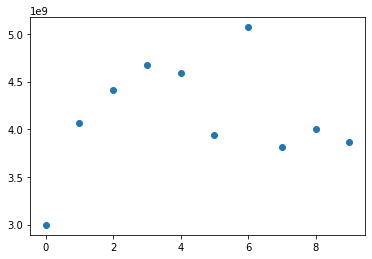

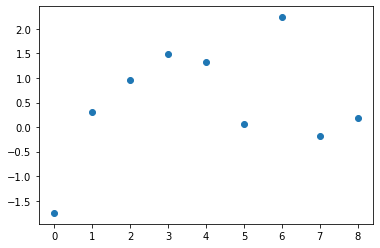

ss20_vols_1    -1.75561
ss20_vols_2    0.298648
ss20_vols_3    0.967985
ss20_vols_4    1.489377
ss20_vols_5    1.324671
ss20_vols_6    0.066605
ss20_vols_7    2.243873
ss20_vols_8    -0.17921
ss20_vols_9    0.193911
Name: 0, dtype: object

In [257]:
data = df_analisys_02.iloc[-10:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss20_vols_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

data

In [258]:
# Create variable names lists to naming columns

ls_ss80vars = ['ss80_vols_' + str(x) for x in range(80,0,-1)]
ls_ss80vars

ls_ss20vars = ['ss20_vols_' + str(x) for x in range(20,8,-1) ]
ls_ss20vars

ls_ss20vars2 = ['ss20_vols_' + str(x) for x in range(8,0,-1) ]
ls_ss20vars2

ls_slopevars = ['slope_vols_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_vols_0', 'slope_vols_1', 'slope_vols_2', 'slope_vols_3']

In [259]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss20vars2] = df_vols_info_01[ls_ss20vars2].astype(float)
df_vols_info_01[ls_ss20vars] = df_vols_info_01[ls_ss20vars].astype(float)
df_vols_info_01[ls_ss80vars] = df_vols_info_01[ls_ss80vars].astype(float)
df_vols_info_01[ls_slopevars] = df_vols_info_01[ls_slopevars].astype(float)

In [260]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01[ls_slopevars + ls_ss20vars2 + ls_ss20vars + ls_ss80vars].info()


(722, 105)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Columns: 104 entries, slope_vols_0 to ss80_vols_1
dtypes: float64(104)
memory usage: 586.8 KB


In [261]:
#Defines X vector to all process

X = df_vols_info_01[ls_ss20vars + ls_ss80vars + ls_slopevars + ls_ss20vars2]
print(X.shape)


(722, 104)


In [262]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss20vars2),
                                     ("pca1", pca_pip, ls_ss20vars),
                                     ("pca2", pca_pip, ls_ss80vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [263]:
Xtr.shape

(722, 18)

In [264]:
#Defines the df of all transformations

ls_ss20pcavars = ['ss20_vols_c1','ss20_vols_c2','ss20_vols_c3']
ls_ss80pcavars = ['ss80_vols_c1','ss80_vols_c2','ss80_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss20vars2 + ls_ss20pcavars + ls_ss80pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(722, 18)


,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1,ss20_vols_c1,ss20_vols_c2,ss20_vols_c3,ss80_vols_c1,ss80_vols_c2,ss80_vols_c3
0,-1.361797,-0.735129,-0.213001,0.081545,-0.179210,2.243873,0.066605,1.324671,1.489377,0.967985,0.298648,-1.755610,0.574010,-0.448594,1.972645,4.381314,-1.787079,-0.117342
1,-0.641822,0.011578,0.070120,0.203410,0.146686,-0.255550,2.356612,0.009447,1.365682,1.543241,0.981163,0.259596,0.661145,-0.139226,2.127375,4.515449,-1.982572,0.070872
2,-0.192136,-0.121632,0.206136,0.191070,-0.107334,0.176194,-0.225782,2.384693,0.039043,1.394403,1.571847,1.010132,0.544002,0.116987,1.155183,4.358672,-2.009494,-0.039284
3,0.786980,0.267491,0.311230,0.133489,-0.631294,-0.044852,0.246288,-0.166481,2.514087,0.105455,1.497207,1.679416,0.545192,0.056457,-0.017016,4.171039,-1.987790,-0.178337
4,-0.549388,0.299716,0.355114,0.116453,-0.875555,-0.604037,0.029635,0.344223,-0.101789,2.794661,0.192048,1.695886,0.428052,-0.450249,-0.991523,3.938490,-1.970166,-0.349296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.929464,0.392182,0.201096,0.038600,-1.154010,1.092914,0.436661,0.353144,-0.270343,-0.727854,2.095614,1.131075,1.779290,-1.191581,-0.777387,-2.682595,2.292457,0.014874
718,1.223478,0.231349,0.100234,0.071502,0.735535,-1.120756,1.203091,0.524372,0.437996,-0.206837,-0.680010,2.240119,1.242932,-1.714633,-0.600573,-2.857775,2.271162,-0.572899
719,-0.637578,-0.512958,-0.177335,0.040656,1.323103,0.925995,-1.191223,1.459273,0.685150,0.586633,-0.148840,-0.688524,0.129786,-2.185361,-0.578448,-3.029103,2.396218,-1.098721
720,-0.390577,0.113534,-0.069477,0.108400,0.338393,1.118106,0.746155,-1.236931,1.245648,0.520569,0.428292,-0.260585,-1.028968,-2.519255,-0.262730,-2.886924,2.355490,-1.298201


In [265]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['date'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,date,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1,ss20_vols_c1,ss20_vols_c2,ss20_vols_c3,ss80_vols_c1,ss80_vols_c2,ss80_vols_c3
0,2022-03-04,-1.361797,-0.735129,-0.213001,0.081545,-0.179210,2.243873,0.066605,1.324671,1.489377,0.967985,0.298648,-1.755610,0.574010,-0.448594,1.972645,4.381314,-1.787079,-0.117342
1,2022-03-03,-0.641822,0.011578,0.070120,0.203410,0.146686,-0.255550,2.356612,0.009447,1.365682,1.543241,0.981163,0.259596,0.661145,-0.139226,2.127375,4.515449,-1.982572,0.070872
2,2022-03-02,-0.192136,-0.121632,0.206136,0.191070,-0.107334,0.176194,-0.225782,2.384693,0.039043,1.394403,1.571847,1.010132,0.544002,0.116987,1.155183,4.358672,-2.009494,-0.039284
3,2022-03-01,0.786980,0.267491,0.311230,0.133489,-0.631294,-0.044852,0.246288,-0.166481,2.514087,0.105455,1.497207,1.679416,0.545192,0.056457,-0.017016,4.171039,-1.987790,-0.178337
4,2022-02-28,-0.549388,0.299716,0.355114,0.116453,-0.875555,-0.604037,0.029635,0.344223,-0.101789,2.794661,0.192048,1.695886,0.428052,-0.450249,-0.991523,3.938490,-1.970166,-0.349296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2019-05-01,0.929464,0.392182,0.201096,0.038600,-1.154010,1.092914,0.436661,0.353144,-0.270343,-0.727854,2.095614,1.131075,1.779290,-1.191581,-0.777387,-2.682595,2.292457,0.014874
718,2019-04-30,1.223478,0.231349,0.100234,0.071502,0.735535,-1.120756,1.203091,0.524372,0.437996,-0.206837,-0.680010,2.240119,1.242932,-1.714633,-0.600573,-2.857775,2.271162,-0.572899
719,2019-04-29,-0.637578,-0.512958,-0.177335,0.040656,1.323103,0.925995,-1.191223,1.459273,0.685150,0.586633,-0.148840,-0.688524,0.129786,-2.185361,-0.578448,-3.029103,2.396218,-1.098721
720,2019-04-26,-0.390577,0.113534,-0.069477,0.108400,0.338393,1.118106,0.746155,-1.236931,1.245648,0.520569,0.428292,-0.260585,-1.028968,-2.519255,-0.262730,-2.886924,2.355490,-1.298201


In [266]:
pd.concat([df_vols_info_tr_01[['date'] +ls_ss20vars2].iloc[0:1,:],
           df_vols_info_01[['date'] +ls_ss20vars2].iloc[0:1,:]],axis=0)

,date,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1
0,2022-03-04,-0.17921,2.243873,0.066605,1.324671,1.489377,0.967985,0.298648,-1.75561
0,2022-03-04,-0.17921,2.243873,0.066605,1.324671,1.489377,0.967985,0.298648,-1.75561


# Attaches target variable to the df with transformations

In [267]:
ls_tgcols = ['date','Close','target_order','target_order_bin','target_close','target_difference','target_date','target_date_diff']


df_transformations_100 = pd.merge(df_close_info_tr_01,
                           df_macdh_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()

df_transformations_100 = pd.merge(df_transformations_100,
                           df_macd_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()

df_transformations_100 = pd.merge(df_transformations_100,
                           df_vols_info_tr_01,
                           on = ['date'],
                           how='inner'
                         ).copy()

df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_02[ls_tgcols],
                           on = ['date'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['date']).reset_index(drop=True)

print(df_analisys_100.shape)

print(min(df_analisys_100['date']))
print(max(df_analisys_100['date']))

df_analisys_100


(722, 77)
2019-04-25 00:00:00
2022-03-04 00:00:00


,date,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,...,ss80_vols_c1,ss80_vols_c2,ss80_vols_c3,Close,target_order,target_order_bin,target_close,target_difference,target_date,target_date_diff
0,2019-04-25,-0.032779,0.053738,0.036135,0.031589,1.288382,1.301302,1.243599,1.283581,1.309245,...,-2.651783,2.385338,-1.394870,2926.169922,SELL2,0,2811.870117,-114.0,2019-05-13,25920.0
1,2019-04-26,0.055995,0.049930,0.047577,0.038838,1.273818,1.215206,1.255818,1.281887,1.509858,...,-2.886924,2.355490,-1.298201,2939.879883,SELL2,0,2879.419922,-60.0,2019-05-08,17280.0
2,2019-04-29,0.076041,0.028261,0.055891,0.039032,1.187384,1.228697,1.255216,1.487128,1.429128,...,-3.029103,2.396218,-1.098721,2943.030029,SELL2,0,2879.419922,-64.0,2019-05-08,12960.0
3,2019-04-30,0.027919,0.050693,0.053447,0.041246,1.219844,1.247433,1.488698,1.428359,1.418223,...,-2.857775,2.271162,-0.572899,2945.830078,SELL,0,2884.050049,-62.0,2019-05-07,10080.0
4,2019-05-01,-0.092560,0.001027,0.026505,0.032828,1.228061,1.474664,1.412990,1.402630,1.534132,...,-2.682595,2.292457,0.014874,2923.729980,SELL2,0,2811.870117,-112.0,2019-05-13,17280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2022-02-28,0.306171,0.213725,-0.080844,-0.133556,-0.841844,-1.522506,-1.748002,-2.064881,-2.634265,...,3.938490,-1.970166,-0.349296,4373.939941,SELL,0,4306.259766,-68.0,2022-03-01,1440.0
718,2022-03-01,-0.274951,0.173100,-0.007498,-0.100218,-1.455657,-1.675853,-1.985284,-2.541287,-2.097941,...,4.171039,-1.987790,-0.178337,4306.259766,BUY,1,4386.540039,80.0,2022-03-02,1440.0
719,2022-03-02,0.043780,0.081507,0.067214,-0.062457,-1.634654,-1.941186,-2.491979,-2.052788,-1.386013,...,4.358672,-2.009494,-0.039284,4386.540039,NULL,0,NaN,NaN,NaT,NaN
720,2022-03-03,0.196820,-0.020441,0.103032,-0.048759,-1.892617,-2.437777,-2.003077,-1.343120,-1.416785,...,4.515449,-1.982572,0.070872,4363.490234,NULL,0,NaN,NaN,NaT,NaN


In [268]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           246
1   BUY2           181
4   NULL             3
2   SELL           180
3  SELL2           112


In [269]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_daily_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(722, 77)
2022-03-04 18:09:44.276626
